Objective: Use the K-Means algorithm to segment customers based on their sales value and order frequency.

Load Data and Prepare for Segmentation
We'll aggregate the data by customer to understand their overall value and frequency.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the feature-engineered data
df = pd.read_csv('../data/processed/final_features.csv')

# Aggregate data to get a per-customer view
customer_df = df.groupby('customer_id').agg(
    total_sales=('sales_per_customer', 'sum'),
    order_frequency=('order_item_id', 'count') # Assuming one item per row
).reset_index()

print("Customer Aggregated Data:")
print(customer_df.head())

Customer Aggregated Data:
   customer_id  total_sales  order_frequency
0            1   472.450012                1
1            2  1618.660042               10
2            3  3189.200037               18
3            4  1480.709993               14
4            5  1101.919998                7


Scale the Features
K-Means is sensitive to the scale of the data. We need to standardize our features so that total_sales doesn't disproportionately influence the result over order_frequency.

In [2]:
# Select features for clustering
features_to_scale = customer_df[['total_sales', 'order_frequency']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

Find the Optimal Number of Clusters (Elbow Method)
We'll run K-Means for a range of cluster numbers and plot the "inertia" (sum of squared distances to the closest centroid). The "elbow" of the curve suggests a good number of clusters.

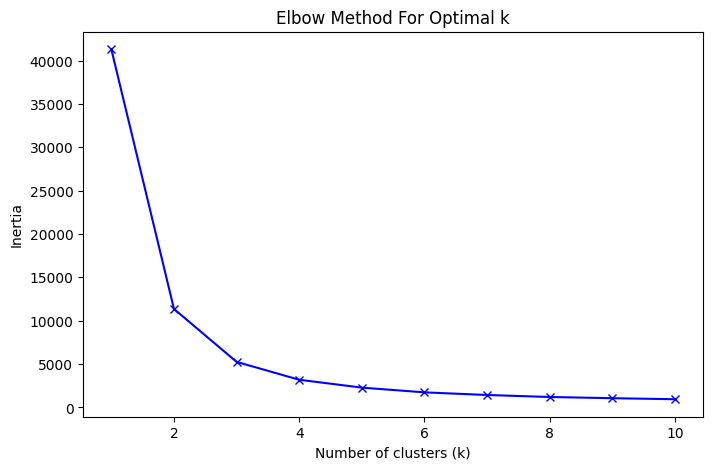

In [3]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

Run K-Means and Analyze Segments
Let's assume the elbow plot suggests k=4. We'll now run K-Means with 4 clusters and analyze the characteristics of each segment.


Average Values per Cluster:
         total_sales  order_frequency
cluster                              
0        1752.193402        10.009690
1         321.846909         1.420253
2        4843.072930        26.423146
3        3101.947846        17.202905


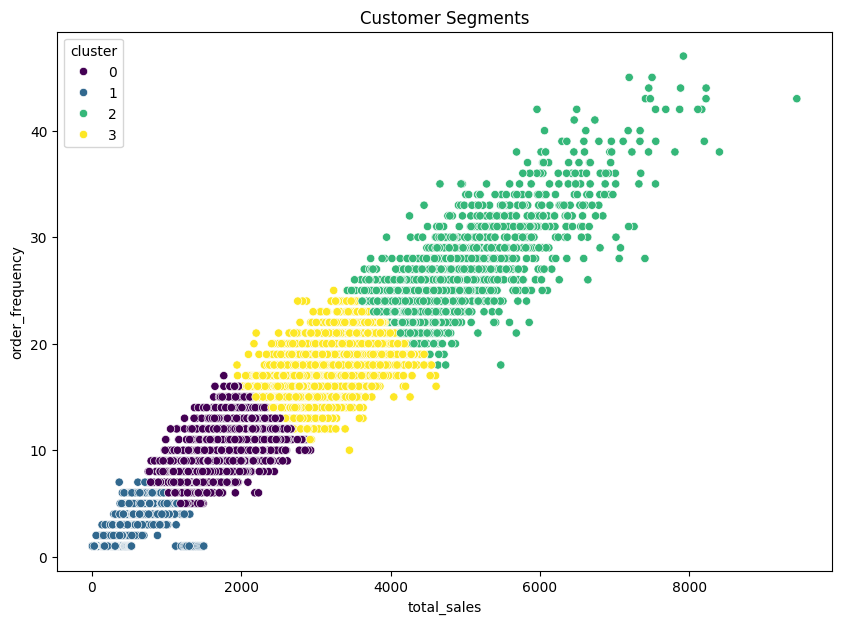

In [4]:
# Run K-Means with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['cluster'] = kmeans.fit_predict(scaled_features)

# Analyze the resulting clusters
cluster_analysis = customer_df.groupby('cluster')[['total_sales', 'order_frequency']].mean()
print("\nAverage Values per Cluster:")
print(cluster_analysis)

# Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=customer_df, x='total_sales', y='order_frequency', hue='cluster', palette='viridis')
plt.title('Customer Segments')
plt.show()

This analysis might reveal segments like "High-Value Frequent Shoppers," "Occasional Big Spenders," or "Low-Value New Customers."

In [5]:
import joblib

# After training the kmeans model, save it to a file
joblib.dump(kmeans, '../models/customer_segmenter.joblib')

print("K-Means model saved successfully as 'customer_segmenter.joblib'")

K-Means model saved successfully as 'customer_segmenter.joblib'


In [6]:
# Create a new dataframe with just the customer ID and their cluster
customer_segments = customer_df[['customer_id', 'cluster']]

# Save this to a new file in the processed data folder
output_path = '../data/processed/customer_segments.csv'
customer_segments.to_csv(output_path, index=False)

print(f"Customer segments saved successfully to {output_path}")

Customer segments saved successfully to ../data/processed/customer_segments.csv
